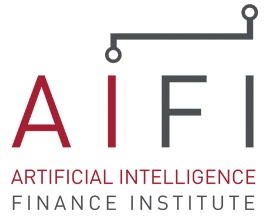


# Bootcamp - Python and Coding

# Machine Learning with scikit-learn

# Portfolio Management-Eigen Portfolio with PCA

# About this notebook

The goal of this notebook is to demonstrate how to use sklearn's [principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA) for portfolio management and allocation.

The goal is to maximize risk-adjusted returns using PCA on a dataset of stocks to allocate capital into different asset classes.

The dataset used for this notebook is Dow Jones Industrial Average (DJIA) index and its respective 30 stocks from year 2000 onwards. The dataset was downloaded from yahoo finance. 

Looking later at the backtesting result, the portfolio with the best result in the training set leads to the best result in the test set. By using PCA, we get independent eigen portfolios with higher return and sharp ratio as compared to market.

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd

# plotting imports
from pylab import mpl, plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

from importlib import reload 
import sys
import os

# sklearn imports
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

#ignore warnings
import warnings
warnings.filterwarnings(action='ignore')

# custom library
py_file_location = '../../'
sys.path.append(os.path.abspath(py_file_location))
from customlib import technical_analysis as ta
from customlib import plotting as pl

In [2]:
# custom styled plotting settings
%matplotlib inline
#sns.set_style('whitegrid', {'axes.facecolor': '.95'})
plt.style.use('../../custom_plot_style.mplstyle') # use the custom style sheet

# use custom styed font and image settings 
mpl.rcParams['font.family'] = 'sans-serif' 
mpl.rcParams['font.sans-serif'] = ['Tahoma']
%config InlineBackend.figure_format = 'svg'

## Loading the Data

In [3]:
PATH = '../../data/'

In [4]:
# load dataset
dataset = pd.read_csv(PATH + 'Dow_adjcloses.csv', index_col=0)

# Exploratory Data Analysis

## Descriptive Statistics

In [5]:
# shape
dataset.shape

(4804, 30)

In [6]:
# get some more intuition of the dataset
set_option('display.width', 100)
dataset.head(2)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.52222,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.89986,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354


In [7]:
# check data types
set_option('display.max_rows', 500)
dataset.dtypes

MMM     float64
AXP     float64
AAPL    float64
BA      float64
CAT     float64
CVX     float64
CSCO    float64
KO      float64
DIS     float64
DWDP    float64
XOM     float64
GS      float64
HD      float64
IBM     float64
INTC    float64
JNJ     float64
JPM     float64
MCD     float64
MRK     float64
MSFT    float64
NKE     float64
PFE     float64
PG      float64
TRV     float64
UTX     float64
UNH     float64
VZ      float64
V       float64
WMT     float64
WBA     float64
dtype: object

In [8]:
# describe data
dataset.describe()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
count,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,363.000000,...,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,2741.000000,4804.000000,4804.000000
mean,86.768590,49.659383,49.106634,85.481517,56.697445,61.735451,21.652896,24.983814,46.367724,64.897404,...,23.724266,20.736962,49.959573,55.961115,62.208919,64.417705,27.193436,53.323035,50.766604,41.696637
std,53.941623,22.564051,55.020296,79.084514,34.663396,31.713863,10.074094,10.611235,32.733220,5.768347,...,20.987536,7.629779,19.769481,34.644166,32.626864,62.920008,11.973258,37.647367,17.039732,19.937069
min,25.140195,8.713025,0.827607,17.463252,9.247340,17.565805,6.842430,11.698790,11.018313,49.090000,...,2.594833,8.041066,16.203766,13.286538,14.520547,5.175169,11.209926,9.846111,30.747677,17.317194
25%,51.191601,34.078903,3.899987,37.406768,26.335348,31.820217,14.910132,15.419998,22.044106,62.249826,...,8.036966,15.030615,35.413562,29.906759,34.328042,23.498173,17.433612,18.958517,38.062387,27.704467
50%,63.513883,42.274116,23.316182,58.436552,53.047521,56.941779,18.577993,20.563342,29.521283,66.586254,...,14.146826,18.643331,46.734628,39.823712,55.714581,42.923977,21.556066,45.207207,42.782495,32.705776
75%,122.906370,66.815558,84.007174,112.996317,76.487605,91.687905,24.649935,34.927140,75.833054,69.143042,...,36.544526,25.402775,68.134961,80.767355,92.557058,73.170959,38.995728,76.966054,65.076409,58.164790
max,251.980826,112.420728,231.260273,411.110000,166.832487,128.679825,63.698248,50.400000,117.972904,75.261152,...,85.300186,45.841240,98.030000,146.564192,141.279565,286.330000,60.016174,150.524693,107.009557,90.187639


## Data Visualization

Taking a look at the correlation. More detailed look at the data will be performed after implementing the Dimensionality Reduction Models.

Saving figure:  correlation_matrix_PCA


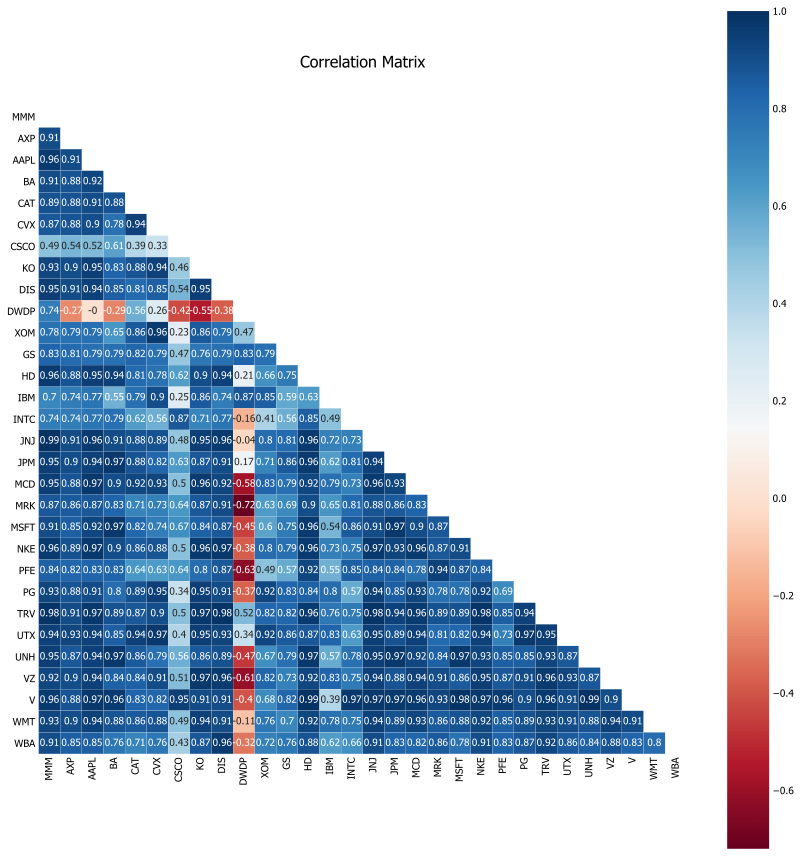

In [9]:
pl.heatmap_plot(dataset, 'Correlation Matrix', 'correlation_matrix_PCA')

As it can be seen by the chart above, there is a significant positive correlation between
the stocks. 

## Data Preparation

## Data Cleaning
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column

In [10]:
# Check for any null values
try:    
    assert(dataset.isnull().values.any() == True)
    missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
    # getting rid of the columns with more than 30% missing values. 
    drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
    # given that there are null values drop the rown contianing the null values.
    dataset.drop(labels=drop_list, axis=1, inplace=True)
    # Fill the missing values with the last value available in the dataset. 
    dataset = dataset.fillna(method='ffill')
    # Drop the rows containing NA
    dataset= dataset.dropna(axis=0)
    
    print('Removed Null values.')
except:
    print('There are no Null values to remove.')

Removed Null values.


### Computing Daily Return

In [11]:
# Daily Log Returns (%)
# datareturns = np.log(data / data.shift(1)) 
# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Remove Outliers beyong 3 standard deviation
datareturns= datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

## Data Transformation

All the variables should be on the same scale before applying PCA, otherwise a feature with large values will dominate the result. Below we use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

Standardization is a useful technique to transform attributes to a standard Normal distribution with a mean of
0 and a standard deviation of 1.

In [12]:
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)

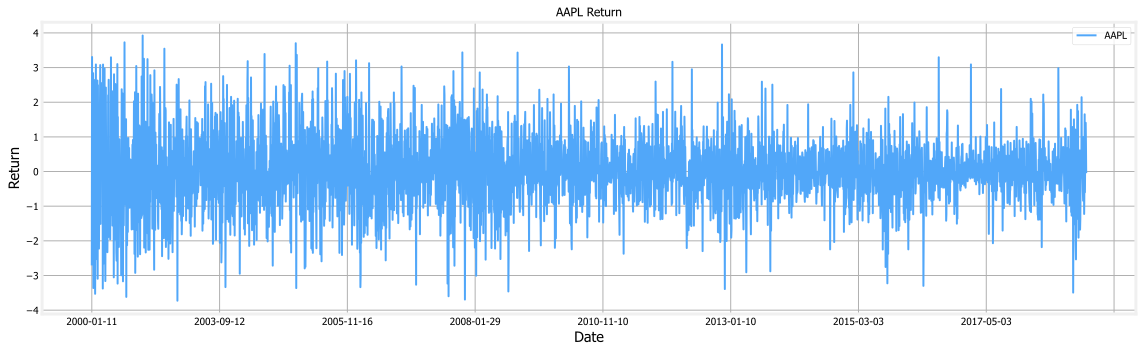

In [13]:
# Visualizing Log Returns for the AAPL 
plt.figure(figsize=(16, 5))
plt.title('AAPL Return')
plt.ylabel('Return')
rescaledDataset.AAPL.plot()
plt.grid(True);
plt.legend();

# Evaluate Algorithms and Models

## Train Test Split

The portfolio is divided into train and test split to perform the analysis regarding the best porfolio and backtesting shown later. 

In [14]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]

stock_tickers = rescaledDataset.columns.values
n_tickers = len(stock_tickers)

## Model Evaluation- Applying Principle Component Analysis

As this step, we create a function to compute principle component analysis from sklearn. This function computes an inversed elbow chart that shows the amount of principle components and how many of them explain the variance treshold.

In [15]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

### First Principal Component /Eigenvector

In [16]:
pca.components_[0]

array([-0.2278224 , -0.22835766, -0.15302828, -0.18969933, -0.20200012,
       -0.17810558, -0.19508121, -0.16845303, -0.20820442, -0.19308548,
       -0.20879404, -0.20231768, -0.19939638, -0.19521427, -0.16686975,
       -0.22806024, -0.15153408, -0.169941  , -0.19367262, -0.17118841,
       -0.18993347, -0.16805969, -0.197612  , -0.22658993, -0.13821257,
       -0.16688803, -0.16897835, -0.16070821])

## Explained Variance using PCA

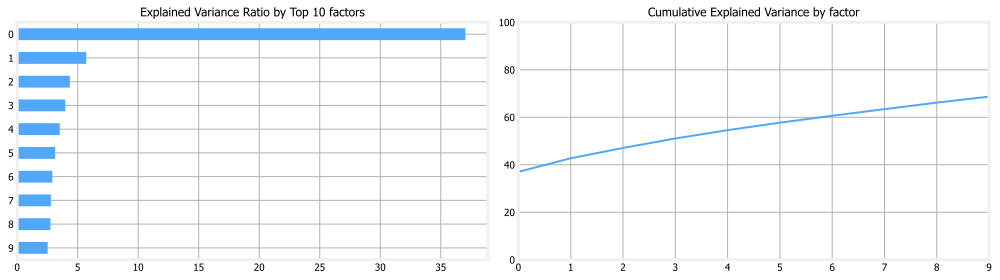

In [17]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');

In [18]:
# explained_variance
explained_var = pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame(
    'Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

We find that the most important factor explains around 40% of the daily return variation. The dominant factor is usually interpreted as ‘the market’, depending on the results of closer inspection.

The plot on the right shows the cumulative explained variance and indicates that around 10 factors explain 73% of the returns of this large cross-section of stocks.  

## Looking at Portfolio weights

We compute several functions to determine the weights of each principle component. We then visualize a scatterplot that visualizes an organized descending plot with the respective weight of every company at the current chosen principle component.

In [19]:
weights = ta.PCWeights(pca)

In [20]:
weights[0]

array([0.04341287, 0.04351486, 0.02916042, 0.0361483 , 0.03849228,
       0.03393904, 0.03717385, 0.03209969, 0.03967455, 0.03679355,
       0.0397869 , 0.0385528 , 0.03799613, 0.0371992 , 0.03179799,
       0.04345819, 0.02887569, 0.03238323, 0.03690543, 0.03262094,
       0.03619291, 0.03202474, 0.0376561 , 0.04317801, 0.0263372 ,
       0.03180147, 0.0321998 , 0.03062387])

In [21]:
pca.components_[0]

array([-0.2278224 , -0.22835766, -0.15302828, -0.18969933, -0.20200012,
       -0.17810558, -0.19508121, -0.16845303, -0.20820442, -0.19308548,
       -0.20879404, -0.20231768, -0.19939638, -0.19521427, -0.16686975,
       -0.22806024, -0.15153408, -0.169941  , -0.19367262, -0.17118841,
       -0.18993347, -0.16805969, -0.197612  , -0.22658993, -0.13821257,
       -0.16688803, -0.16897835, -0.16070821])

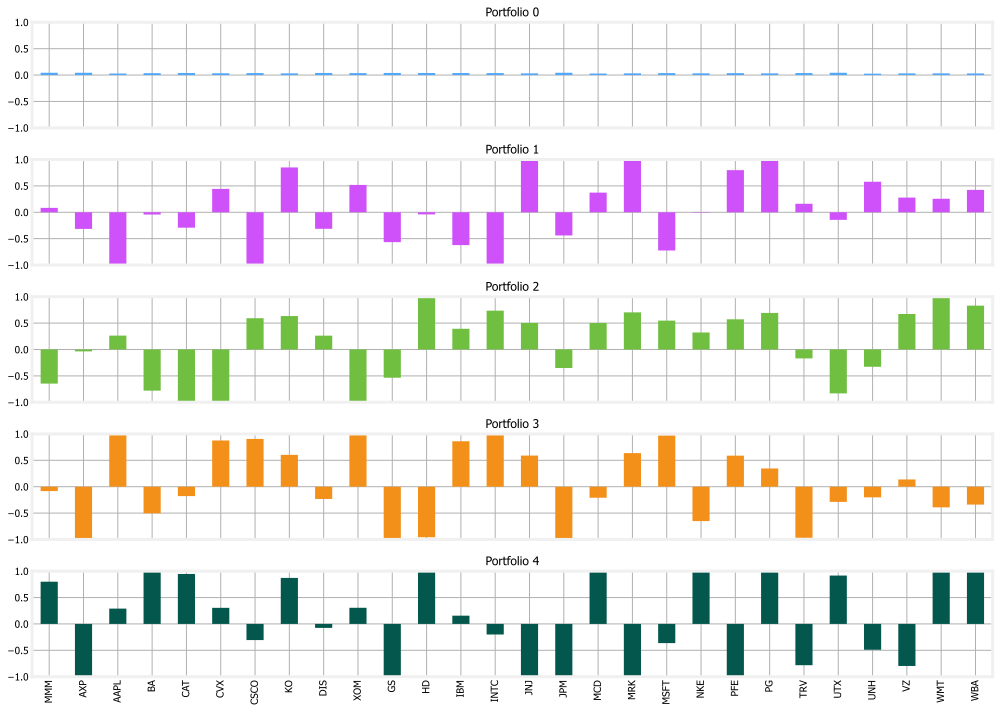

In [22]:
NumComponents=5
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=dataset.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1));

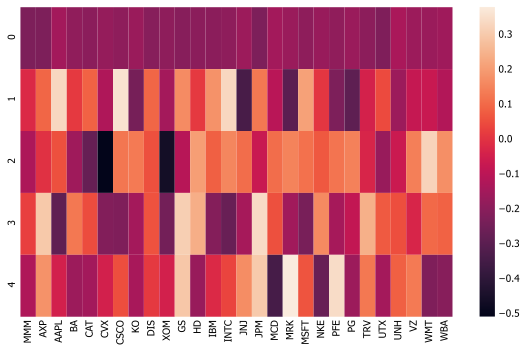

In [23]:
# plotting heatmap 
sns.heatmap(topPortfolios); 

The heatmap and the plot above shown the contribution of different stocks in each
eigenvector.

## Finding the Best Eigen Portfolio

In order to find the best eigen portfolios and perform backtesting in the next step, we use the sharpe ratio, which is a performance
metric that explains the annualized returns against the annualized volatility of each company in a portfolio. A high sharpe ratio explains higher returns and/or lower volatility for the specified portfolio. The annualized sharpe ratio is computed by dividing
the annualized returns against the annualized volatility. For annualized return we
apply the geometric average of all the returns in respect to the periods per year (days
of operations in the exchange in a year). Annualized volatility is computed by taking the standard deviation of the returns and multiplying it by the square root of the periods per year.

We construct a loop to compute the principle component’s weights for each eigen
portfolio, which then uses the sharpe ratio function to look for the portfolio with the
highest sharpe ratio. Once we know which portfolio has the highest sharpe ratio, we
can visualize its performance against the DJIA Index for comparison.

Eigen portfolio #0 with the highest Sharpe. Return 11.47%, vol = 13.31%, Sharpe = 0.86
     Return       Vol    Sharpe
0  0.114739  0.133133  0.861838
7  0.095771  0.693481  0.138102
5  0.100020  0.844943  0.118375
1  0.056561  0.670429  0.084366
2 -0.106559  0.858820 -0.124076


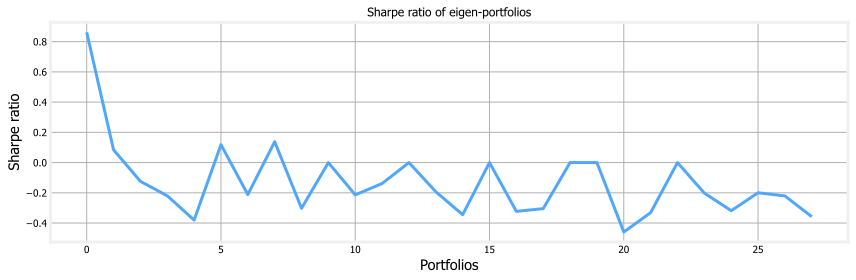

In [24]:
ta.optimizedPortfolio(pca, rescaledDataset, X_train_raw)

As shown from the results above, the portfolio 0 is the best portfolio and has the maximum sharp ratio out of all the porfolio. Let us look at the composition of this portfolio. 

Sum of weights of current eigen-portfolio: 100.00


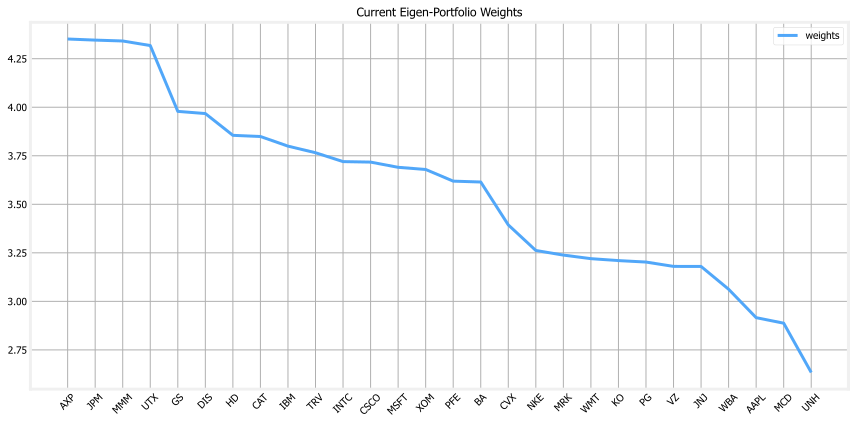

In [25]:
weights = ta.PCWeights(pca)

# Weights are stored in arrays, where 0 is the first PC's weights.
ta.plotEigen(weights[0], stock_tickers, plot=True)

The chart shows the allocation of the best portfolio. The weights in the chart are in
percentages. 

## Backtesting Eigenportfolio

As shown in the plots below the eigen portfolio return of the top portfolios outperform the equally weighted portfolio and the eigen portfolio ranked 19 underperformed the market significantly in the test set. 

Current Eigen-Portfolio:
Return = 32.76%
Volatility = 68.64%
Sharpe = 0.48
Current Eigen-Portfolio:
Return = 99.80%
Volatility = 58.34%
Sharpe = 1.71
Current Eigen-Portfolio:
Return = -79.42%
Volatility = 185.30%
Sharpe = -0.43


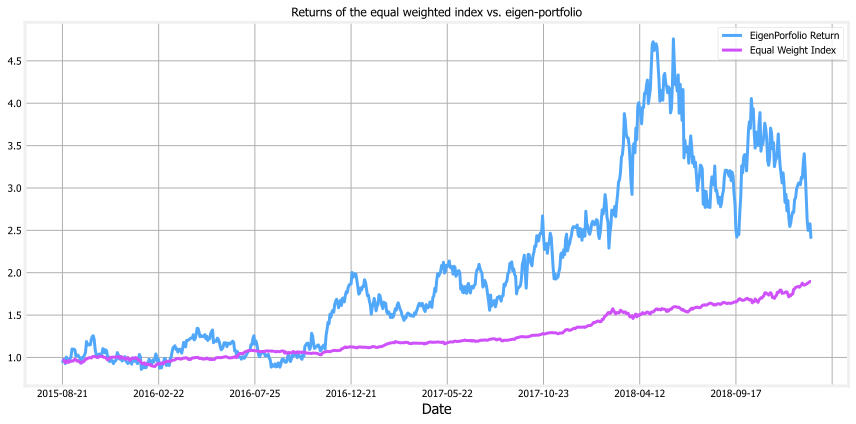

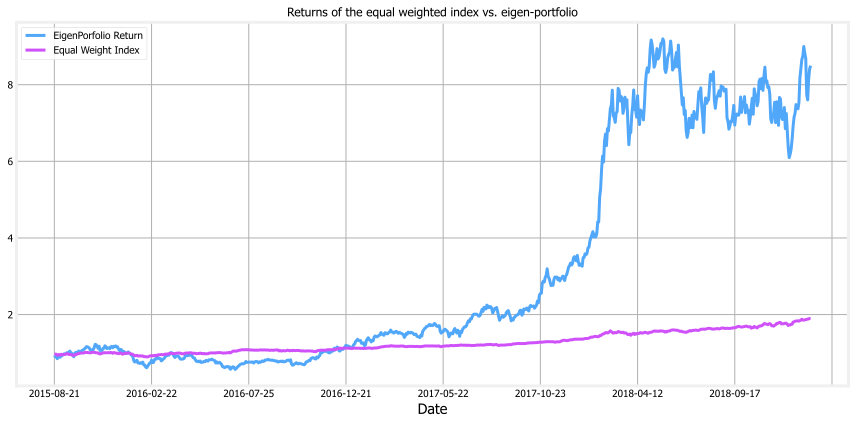

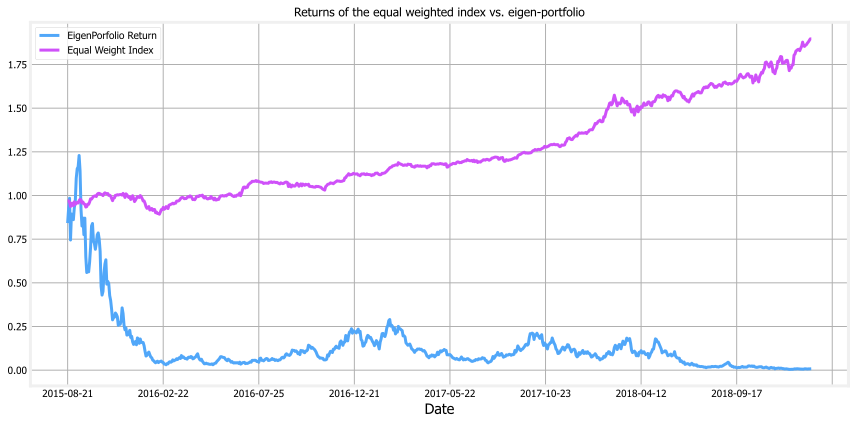

In [27]:
# backtest
ta.Backtest(weights[5], stock_tickers, X_test_raw,  pca, X_test)
ta.Backtest(weights[1], stock_tickers, X_test_raw,  pca, X_test)
ta.Backtest(weights[14], stock_tickers, X_test_raw,  pca, X_test)